In [143]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!tar -xvf "/content/gdrive/My Drive/iss/prpm/data/cloth_96x128.tar.gz" -C "/content"

## **Import tensorflow libraries**
---

In [145]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import subtract
from tensorflow.keras.layers import multiply
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets.fashion_mnist import load_data # example of loading the fashion_mnist dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import os
import pathlib
from matplotlib import pyplot
from PIL import Image
# from IPython.display import Image 

## **Load image data from local disk**
---

In [146]:
def load_images(directory):
  imagedata = []

  # load the image
  for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
      img = Image.open(os.path.join(directory, filename))
      img_array = np.array(img) # convert to numpy array
      img_array = img_array.astype('float32')
      img_array = (img_array - 127.5) / 127.5 # scale from [0,255] to [-1,1]
      imagedata.append(img_array)   

  imagedata = np.array(imagedata, dtype='float32')
  return imagedata

def display_image_arr(image_arr):
  img_array = (image_arr * 127.5) + 127.5
  img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
  display(img)

In [147]:
all_images = load_images('/content/cloth_96x128')
print("shape:", all_images.shape)

shape: (14221, 128, 96, 3)


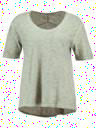

In [148]:
display_image_arr(all_images[999] + np.random.normal(0, 0.004, all_images[2].shape))

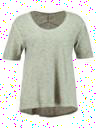

In [149]:
display_image_arr(K.reverse(all_images[999],axes=1).numpy() + np.random.normal(0, 0.004, all_images[2].shape))

## **Define GAN model construction functions**
---

In [150]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential(name="discriminator")
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  # plot model
  plot_model(model, to_file="discriminator.png", show_shapes=True, show_layer_names=True, rankdir='TB')
  return model

In [151]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential(name="generator")
  # foundation for 7x7 image
  n_nodes = 128 * 32 * 24 #128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((32, 24, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # generate
  model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
  # model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
  # plot model
  plot_model(model, to_file="generator.png", show_shapes=True, show_layer_names=True, rankdir='TB')
  return model

Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpt (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
generator (Sequential)          (None, 128, 96, 3)   20308227    inpt[0][0]                       
__________________________________________________________________________________________________
VertFlip (Lambda)               (None, 128, 96, 3)   0           generator[1][0]                  
__________________________________________________________________________________________________
subtract_37 (Subtract)          (None, 128, 96, 3)   0           VertFlip[0][0]                   
                                                                 generator[1][0]      

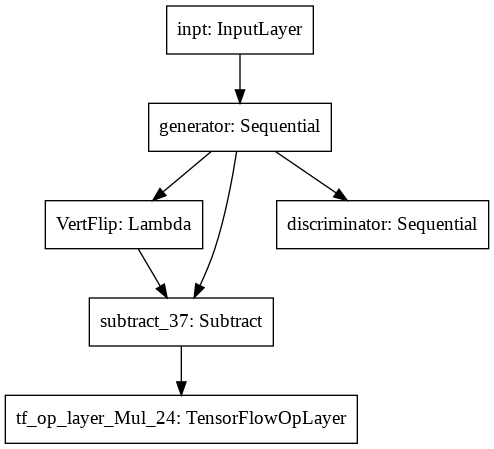

In [190]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False

  latent_dim = generator.layers[0].input.shape[1]
  input = Input(shape=latent_dim,name="inpt")
  g_out = generator(input)

  # normal loss output of gan
  output1 = discriminator(g_out)
  
  # symmetry loss output 
  revLambda = Lambda(lambda x: K.reverse(x,axes=1), name="VertFlip") # lambda layer to flip image wrt vertical axis
  x = revLambda(g_out) 
  x = subtract([x, g_out])
  output2 = tf.math.scalar_mul(0.5, x, name='multi0.5')
  
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model = Model(inputs=input, outputs=[output1, output2])
  model.compile(loss=['binary_crossentropy',"mean_squared_error"], 
                loss_weights=[0.9,0.1], 
                optimizer=opt)
  # plot model
  plot_model(model, to_file="gan.png", show_shapes=True, show_layer_names=True, rankdir='TB')
  return model

gan_model = define_gan(generator, discriminator)
gan_model.summary()
plot_model(gan_model, "g_model.png")

## **Define data preprocessing functions**
---

In [153]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [154]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [155]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

## **Define GAN model training functions**
---

In [182]:
def export_loss_at_interval(loss_array, filepath, idx, interval):
  if idx >= 0 and (idx + 1) % interval == 0:
    np.savetxt(filepath + "loss_RGB_asy.csv", loss_array, delimiter=",", header="epoch,d_real_loss,d_fake_loss,g_loss")
    
def save_models_at_interval(d_model, g_model, gan_model, folderpath, idx, interval):
  if idx > 0 and (idx + 1) % interval == 0:
    # save the gan model
    d_model.trainable = False
    gan_model.save(folderpath + 'gan_RGB_asy_' + str(idx) + '.h5')

    # save the generator model
    d_model.trainable = True
    g_model.save(folderpath + 'generator_RGB_asy_' + str(idx) + '.h5')
    # save the discriminator model
    d_model.save(folderpath + 'discriminator_RGB_asy_' + str(idx) + '.h5')

In [195]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  loss_array = np.empty((0, 4), np.float32)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_real = X_real + tf.random.normal(shape=tf.shape(X_real), mean=0.0, stddev=0.004, dtype=tf.float32)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan1 = ones((n_batch, 1))
      y_gan2 = zeros((n_batch,128,96,3))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, [y_gan1,y_gan2])[0]
      # summarize loss on this batch
      # print('>%d, %d/%d, d_real_loss=%.3f, d_fake_loss=%.6f g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    print('>%d, d_real_loss=%.6f, d_fake_loss=%.6f, g=%.6f' % (i+1, d_loss1, d_loss2, g_loss))

    # save gan model after every 100 epoch
    save_models_at_interval(d_model, g_model, gan_model, '/content/gdrive/My Drive/iss/prpm/pureGAN/', i, 100)
    # save loss after every epoch
    loss_array = np.append(loss_array, np.array([[i, d_loss1, d_loss2, g_loss]]), axis=0)
    export_loss_at_interval(loss_array, '/content/gdrive/My Drive/iss/prpm/pureGAN/', i, 1)

  # save model at end of all epoches
  save_models_at_interval(d_model, g_model, gan_model, '/content/gdrive/My Drive/iss/prpm/pureGAN/', i, 1)

In [192]:
# size of the latent space
latent_dim = 200
# create the discriminator
discriminator = define_discriminator(in_shape=(all_images.shape[1], all_images.shape[2], all_images.shape[3]))
# discriminator = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/discriminator_RGB_300.h5')
# discriminator.summary()
# create the generator
generator = define_generator(latent_dim)
# generator = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/generator_RGB_300.h5')
# generator.summary()
# create the gan
gan_model = define_gan(generator, discriminator)
# gan_model = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/gan_RGB_200.h5')
# gan_model.summary()
# plot_model(gan_model, "g_model.png")

In [ ]:
# load image data
# dataset = load_real_samples()
dataset = all_images #[0:9999]
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=400, n_batch=128)

## **Generate images with trained model**
---

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
def display_image_arr(image_arr):
  img_array = (image_arr * 127.5) + 127.5
  img = Image.fromarray(img_array.astype(np.uint8), 'RGB')
  display(img)
 
# load model
model = load_model('/content/gdrive/My Drive/iss/prpm/pureGAN/generator_delete.h5')
# model.summary()

In [ ]:
# generate images
latent_points = generate_latent_points(100, 9)
# generate images
X = model.predict(latent_points)
# plot the result
# show_plot(X, 1)
for i in range(X.shape[0]):
  display_image_arr(X[i])